[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Combined closing prices saved to MARUTI_TATAMOTORS_ClosingPrices.csv


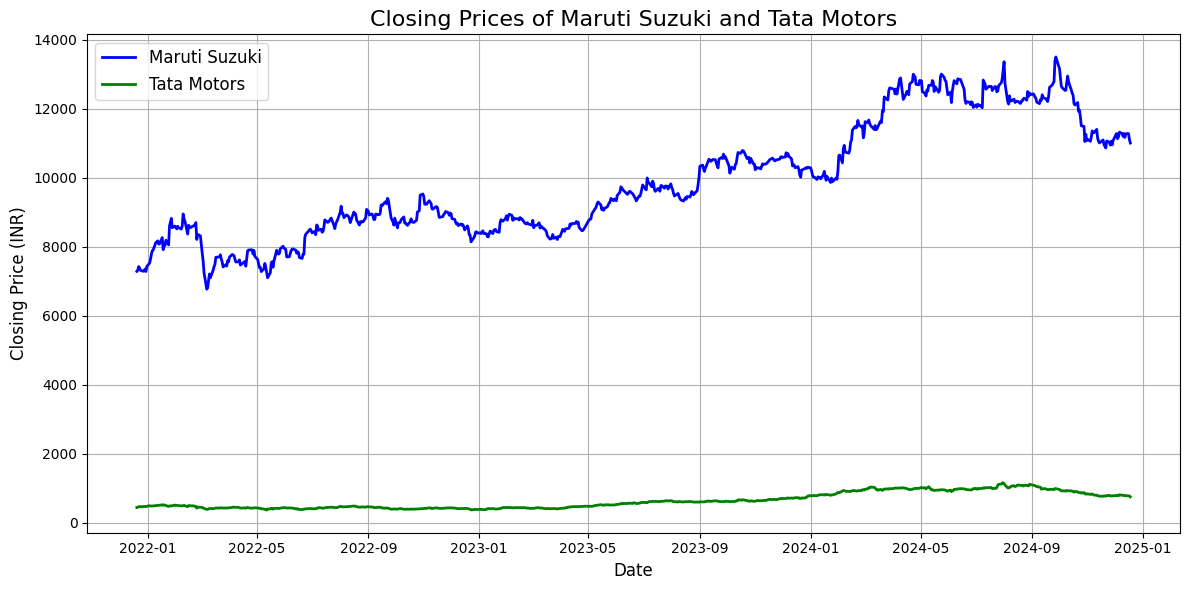

Overall Pearson Correlation: 0.9432


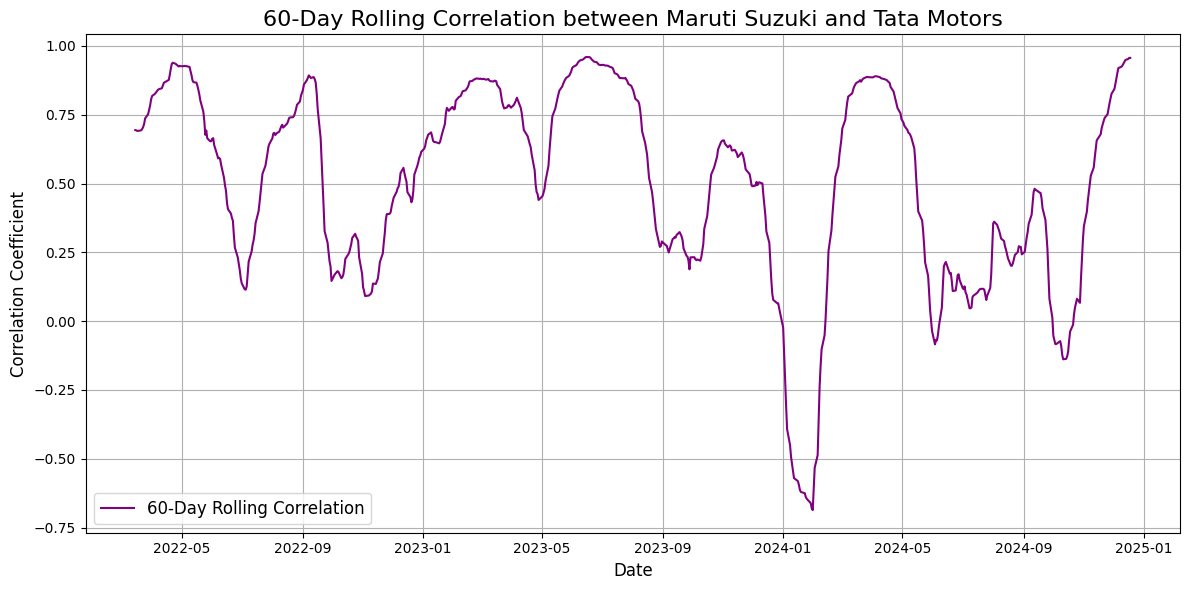


Detailed Correlation Matrix:
               MARUTI.NS  TATAMOTORS.NS
MARUTI.NS       1.000000       0.943157
TATAMOTORS.NS   0.943157       1.000000


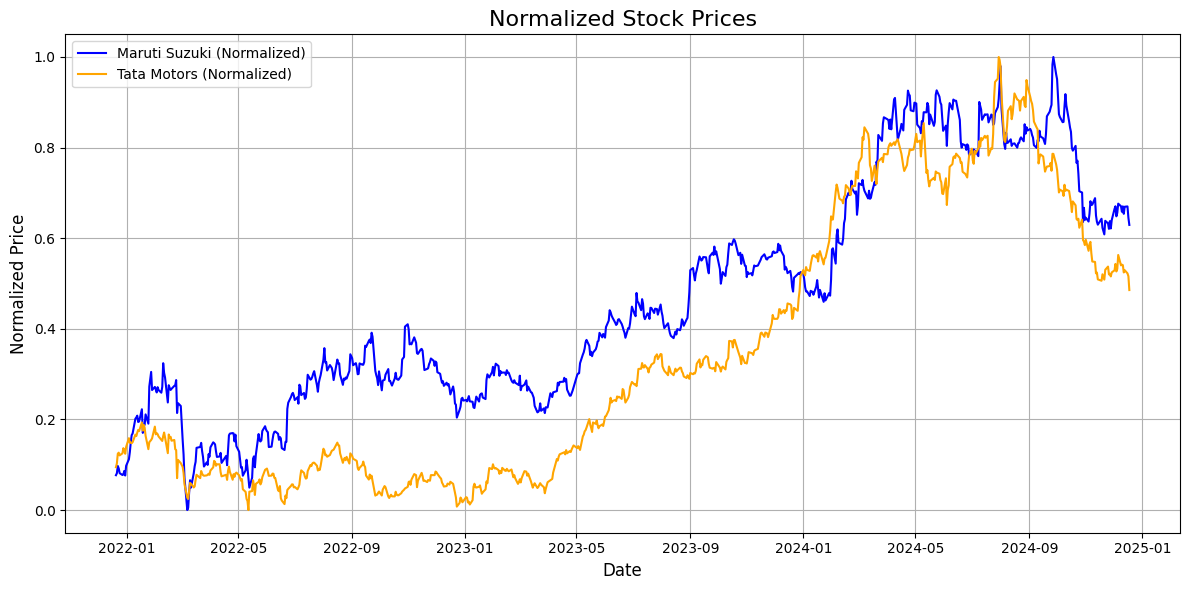

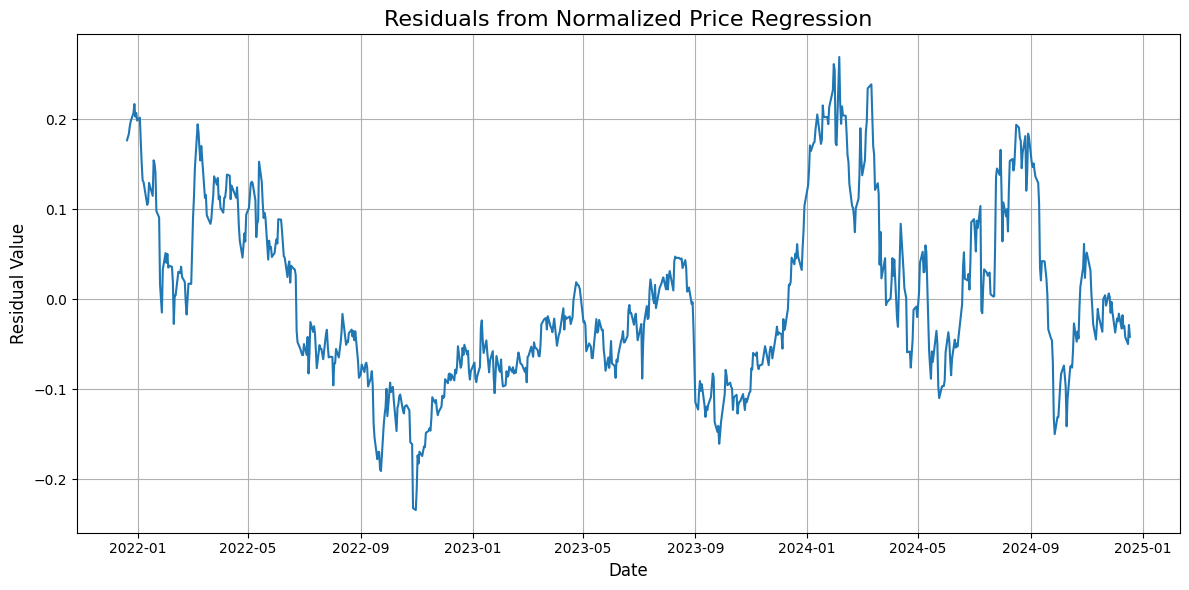


Augmented Dickey-Fuller Test Results:
ADF Statistic: -3.3451418649898255
p-value: 0.01297733532673046
Critical Values:
	1%: -3.4392177416762086
	5%: -2.8654536415414684
	10%: -2.5688540485756026

Interpretation:
The residuals are stationary.
Strong evidence of COINTEGRATION.

Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:          TATAMOTORS.NS   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5952.
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        15:30:26   Log-Likelihood:                 680.87
No. Observations:                 741   AIC:                            -1358.
Df Residuals:                     739   BIC:                            -1349.
Df Model:                           1                    

In [2]:
#importing the important libraries that we will use in this statistical arbitrage strategy.
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Defining the stock symbols and timeframe for Maruti Suzuki and Tata Motors
# The reason for choosing these two stocks is they have very low p-value.
# I will explain later why it was important for us to get a low p-value.
symbols = ["MARUTI.NS", "TATAMOTORS.NS"]
end_date = datetime.today().date() #ending with 18th december date.
start_date = end_date - timedelta(days=3 * 365) # we want to download the data of last 3 years.

closing_prices = pd.DataFrame() # creating a pandas dataframe
for symbol in symbols:
    print(f"Downloading data for {symbol}")
    data = yf.download(symbol, start=start_date, end=end_date, interval="1d") #downloading from yfinance
    closing_prices[symbol] = data['Close'] #saving the closing prices in a single dataframe for both of the stocks.
#saving the data in a single file
file_name = "MARUTI_TATAMOTORS_ClosingPrices.csv"
closing_prices.to_csv(file_name)
print(f"Combined closing prices saved to {file_name}")
closing_prices.head()

# Plotting Closing Prices for both of the stocks
closing_prices = pd.read_csv(file_name, index_col="Date", parse_dates=True)
plt.figure(figsize=(12, 6))
plt.plot(closing_prices.index, closing_prices["MARUTI.NS"], label="Maruti Suzuki", color="blue", linewidth=2)
plt.plot(closing_prices.index, closing_prices["TATAMOTORS.NS"], label="Tata Motors", color="green", linewidth=2)
plt.title("Closing Prices of Maruti Suzuki and Tata Motors", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing Price (INR)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Checking the correlation between these two stocks, a correlation of > 0.8 means the stocks are highly correlated that's what we want but that's not the only thing to check
def perform_correlation_analysis(closing_prices):
    # performing the coorelation part.
    overall_correlation = closing_prices["MARUTI.NS"].corr(closing_prices["TATAMOTORS.NS"])
    print(f"Overall Pearson Correlation: {overall_correlation:.4f}")
    # creating the correlation rolling window for 60 days time period and visualizing it.
    rolling_correlation = closing_prices["MARUTI.NS"].rolling(window=60).corr(closing_prices["TATAMOTORS.NS"])
    plt.figure(figsize=(12, 6))
    plt.plot(closing_prices.index, rolling_correlation, label='60-Day Rolling Correlation', color='purple')
    plt.title('60-Day Rolling Correlation between Maruti Suzuki and Tata Motors', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # just forming a correlation matrix
    correlation_matrix = closing_prices[["MARUTI.NS", "TATAMOTORS.NS"]].corr()
    print("\nDetailed Correlation Matrix:")
    print(correlation_matrix)
    return overall_correlation

results = perform_correlation_analysis(closing_prices)
# Performing Normalized Cointegration Test, this test is most important, we have to check for the p-value, if it is good then then we can select the stock pair
def normalize_prices(series): # normalizing function for the stock prices.
    return (series - series.min()) / (series.max() - series.min())

def perform_normalized_cointegration_test(closing_prices):
    # normalising both of the stock prices.
    x_normalized = normalize_prices(closing_prices["MARUTI.NS"])
    y_normalized = normalize_prices(closing_prices["TATAMOTORS.NS"])
    # plotting the normalised stock prices on the same chart.
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(closing_prices.index, x_normalized, label='Maruti Suzuki (Normalized)', color='blue')
    plt.plot(closing_prices.index, y_normalized, label='Tata Motors (Normalized)', color='orange')
    plt.title('Normalized Stock Prices', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # applying linear regression(ordinary least squares)
    X = sm.add_constant(x_normalized)
    model = sm.OLS(y_normalized, X).fit()
    residuals = model.resid
    # plotting the residuals after performing linear regression.
    plt.figure(figsize=(12, 6))
    plt.plot(closing_prices.index, residuals)
    plt.title('Residuals from Normalized Price Regression', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Residual Value', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # now performing the adf test.
    adf_result = adfuller(residuals.dropna())
    print('\nAugmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}') # this p value is important.
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    print("\nInterpretation:")
    if adf_result[1] <= 0.05:
        print("The residuals are stationary.")
        print("Strong evidence of COINTEGRATION.")
    else:
        print("The residuals are NOT stationary.")
        print("Weak or NO evidence of cointegration.")
    print('\nLinear Regression Model Summary:')
    print(model.summary())
    return {'normalized_prices': {'Maruti Suzuki': x_normalized, 'Tata Motors': y_normalized}, 'residuals': residuals}

normalized_cointegration_results = perform_normalized_cointegration_test(closing_prices)


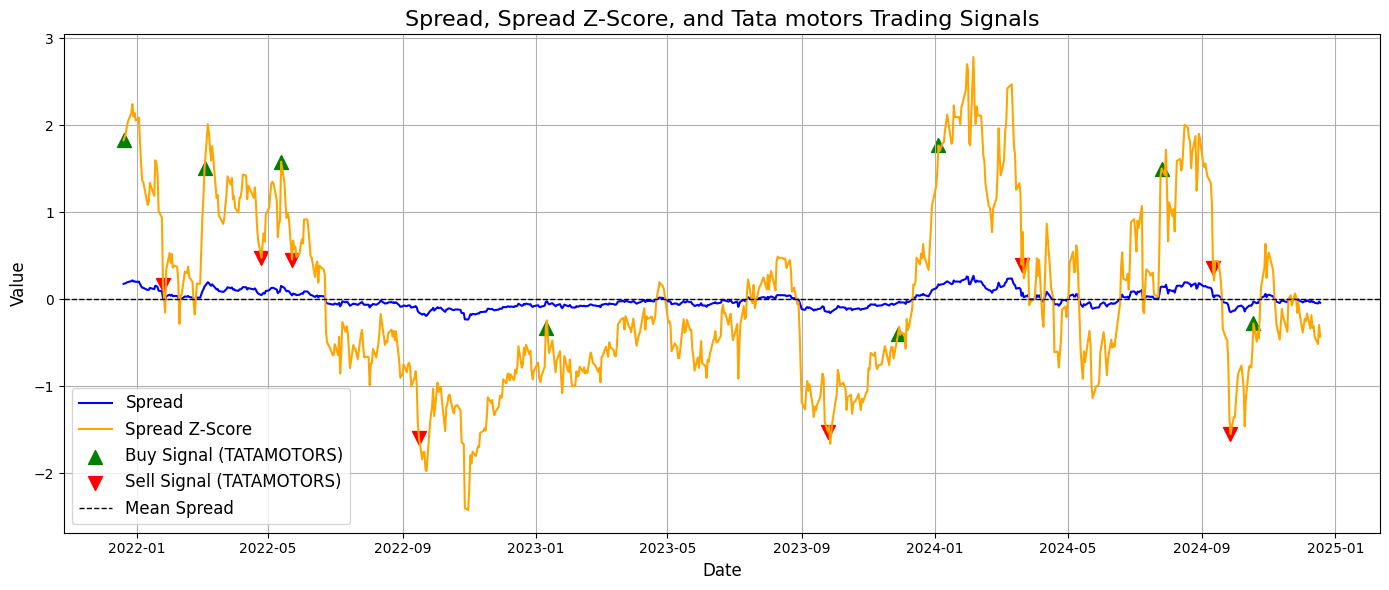

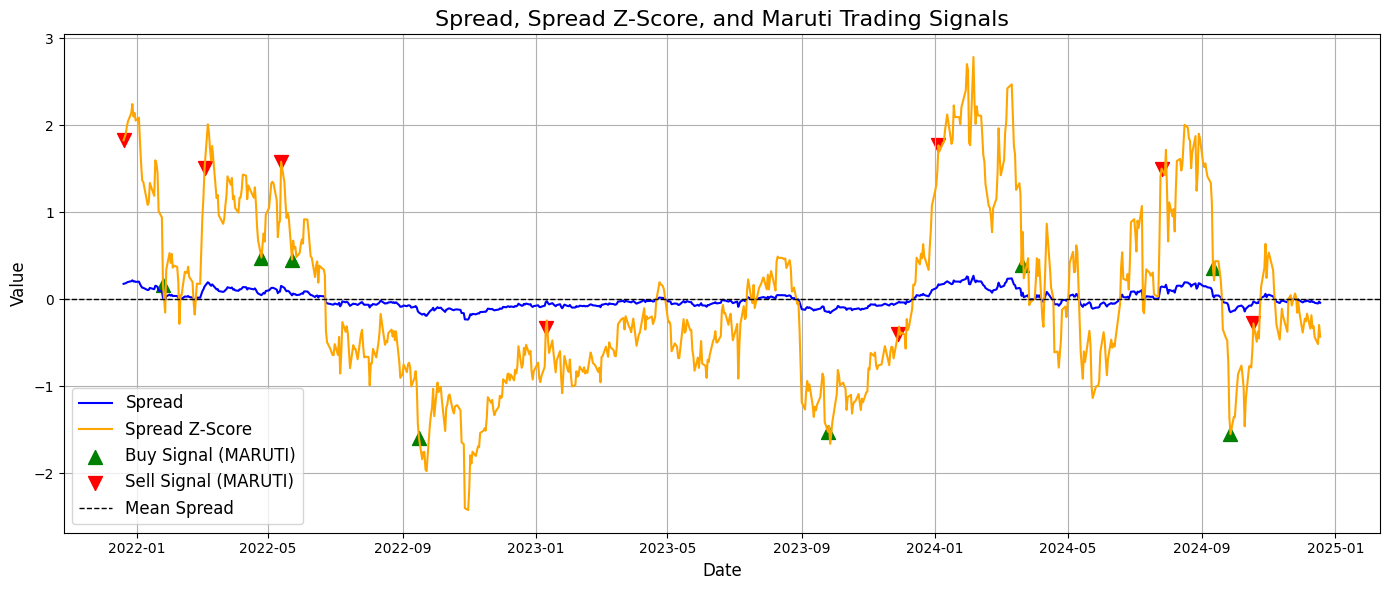

In [5]:
# A p-value of 0.012 indicates a very high chances that we can select these two stocks.
import statsmodels.api as sm

def generate_trading_signals(closing_prices, z_score_threshold=1.5):
    """
    Generating the trading signals.
    Strategy Logic:
    1. Enter a trade when z-score exceeds +/- 1.5
    2. Maintain the position until mean reversion (z-score returns close to 0.5)
    3. On mean reversion, exit with opposite signals
    4. on the basis of z-score we can hyper tune our strategy,
    we can select the optimal values of the z-score through various other machine learning algorithms.

    Parameters:
    -----------
    closing_prices : pandas.DataFrame
        DataFrame containing closing prices for two stocks
    z_score_threshold : 1.5
        Threshold for entering trading positions

    Returns:
    --------
    signals : pandas.DataFrame
        DataFrame containing trading signals and spread information
    """
    # Assuming the first column is the first stock, second column is the second stock
    stock1 = closing_prices.columns[0]
    stock2 = closing_prices.columns[1]

    # Normalize prices
    def normalize_prices(series):
        return (series - series.min()) / (series.max() - series.min())

    x_normalized = normalize_prices(closing_prices[stock1])
    y_normalized = normalize_prices(closing_prices[stock2])

    # Perform linear regression
    X = sm.add_constant(x_normalized)
    model = sm.OLS(y_normalized, X).fit()

    # Calculate spread (residuals)
    spread = model.resid

    # Calculate z-score of the spread
    spread_mean = spread.mean()
    spread_std = spread.std()
    spread_z_score = (spread - spread_mean) / spread_std

    # Initialize signals DataFrame
    signals = pd.DataFrame(index=closing_prices.index)
    signals['spread'] = spread
    signals['spread_z_score'] = spread_z_score
    signals[f'{stock1}_signal'] = 0
    signals[f'{stock2}_signal'] = 0

    # Tracking active positions
    active_long = False
    active_short = False

    for i in range(len(spread_z_score)):
        # Long entry condition
        if spread_z_score.iloc[i] < -z_score_threshold and not active_long and not active_short:
            signals.loc[signals.index[i], f'{stock1}_signal'] = 1  # Long first stock
            signals.loc[signals.index[i], f'{stock2}_signal'] = -1  # Short second stock
            active_long = True

        # Short entry condition
        elif spread_z_score.iloc[i] > z_score_threshold and not active_long and not active_short:
            signals.loc[signals.index[i], f'{stock1}_signal'] = -1  # Short first stock
            signals.loc[signals.index[i], f'{stock2}_signal'] = 1  # Long second stock
            active_short = True

        # Mean reversion exit condition
        elif np.abs(spread_z_score.iloc[i]) < 0.5:
            if active_long:
                # Exit long position with opposite signals
                signals.loc[signals.index[i], f'{stock1}_signal'] = -1  # Close long first stock
                signals.loc[signals.index[i], f'{stock2}_signal'] = 1  # Close short second stock
                active_long = False
            elif active_short:
                # Exit short position with opposite signals
                signals.loc[signals.index[i], f'{stock1}_signal'] = 1  # Close short first stock
                signals.loc[signals.index[i], f'{stock2}_signal'] = -1  # Close long second stock
                active_short = False

    return signals

signals = generate_trading_signals(closing_prices)
signals.head()
# Plotting the buy-sell singals for tata motors(just for validation puposes)
plt.figure(figsize=(14, 6))

# Plot the spread
plt.plot(signals.index, signals['spread'], label='Spread', color='blue', linewidth=1.5)

# Plot the Z-score of the spread
plt.plot(signals.index, signals['spread_z_score'], label='Spread Z-Score', color='orange', linewidth=1.5)

# Plot the signals as markers
buy_signals = signals[signals["TATAMOTORS.NS_signal"] == 1]
sell_signals = signals[signals["TATAMOTORS.NS_signal"] == -1]

# Plot buy signals
plt.scatter(buy_signals.index, buy_signals['spread_z_score'], color='green', label='Buy Signal (TATAMOTORS)', marker='^', s=100)

# Plot sell signals
plt.scatter(sell_signals.index, sell_signals['spread_z_score'], color='red', label='Sell Signal (TATAMOTORS)', marker='v', s=100)

# Adding chart details
plt.title("Spread, Spread Z-Score, and Tata motors Trading Signals", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Mean Spread')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Plotting the buy-sell singals for maruti suzuki(just for validation puposes)
plt.figure(figsize=(14, 6))

# Plot the spread
plt.plot(signals.index, signals['spread'], label='Spread', color='blue', linewidth=1.5)

# Plot the Z-score of the spread
plt.plot(signals.index, signals['spread_z_score'], label='Spread Z-Score', color='orange', linewidth=1.5)

# Plot the signals as markers
buy_signals = signals[signals["MARUTI.NS_signal"] == 1]
sell_signals = signals[signals["MARUTI.NS_signal"] == -1]

# Plot buy signals
plt.scatter(buy_signals.index, buy_signals['spread_z_score'], color='green', label='Buy Signal (MARUTI)', marker='^', s=100)

# Plot sell signals
plt.scatter(sell_signals.index, sell_signals['spread_z_score'], color='red', label='Sell Signal (MARUTI)', marker='v', s=100)

# Add chart details
plt.title("Spread, Spread Z-Score, and Maruti Trading Signals", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Mean Spread')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


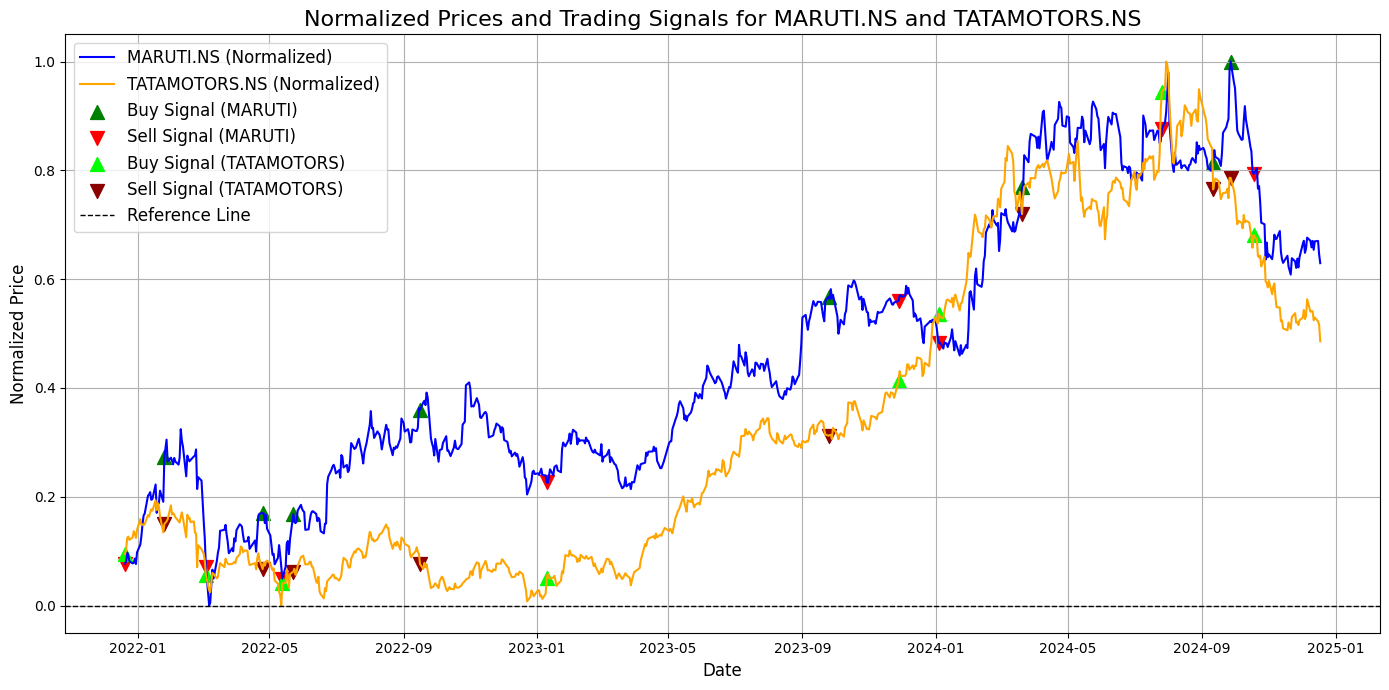

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
# plotting the stock prices and their buy-sell signals just to visualise.
# Function to normalize prices
def normalize_prices(series):
    """Normalize stock prices using Min-Max scaling."""
    return (series - series.min()) / (series.max() - series.min())

# Normalize the stock prices
normalized_prices = closing_prices.apply(normalize_prices)

# Plot normalized prices and signals for both stocks
plt.figure(figsize=(14, 7))

# Plot normalized prices for each stock
plt.plot(normalized_prices.index, normalized_prices["MARUTI.NS"], label="MARUTI.NS (Normalized)", color="blue", linewidth=1.5)
plt.plot(normalized_prices.index, normalized_prices["TATAMOTORS.NS"], label="TATAMOTORS.NS (Normalized)", color="orange", linewidth=1.5)

# Extract buy and sell signals for MARUTI.NS
maruti_buy_signals = signals[signals["MARUTI.NS_signal"] == 1]
maruti_sell_signals = signals[signals["MARUTI.NS_signal"] == -1]

# Plot MARUTI buy and sell signals
plt.scatter(maruti_buy_signals.index, normalized_prices.loc[maruti_buy_signals.index, "MARUTI.NS"],
            color="green", label="Buy Signal (MARUTI)", marker="^", s=100)
plt.scatter(maruti_sell_signals.index, normalized_prices.loc[maruti_sell_signals.index, "MARUTI.NS"],
            color="red", label="Sell Signal (MARUTI)", marker="v", s=100)

# Extract buy and sell signals for TATAMOTORS.NS
tatamotors_buy_signals = signals[signals["TATAMOTORS.NS_signal"] == 1]
tatamotors_sell_signals = signals[signals["TATAMOTORS.NS_signal"] == -1]

# Plot TATAMOTORS buy and sell signals
plt.scatter(tatamotors_buy_signals.index, normalized_prices.loc[tatamotors_buy_signals.index, "TATAMOTORS.NS"],
            color="lime", label="Buy Signal (TATAMOTORS)", marker="^", s=100)
plt.scatter(tatamotors_sell_signals.index, normalized_prices.loc[tatamotors_sell_signals.index, "TATAMOTORS.NS"],
            color="darkred", label="Sell Signal (TATAMOTORS)", marker="v", s=100)

# Add chart details
plt.title("Normalized Prices and Trading Signals for MARUTI.NS and TATAMOTORS.NS", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Price", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Reference Line")
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


[*********************100%***********************]  1 of 1 completed


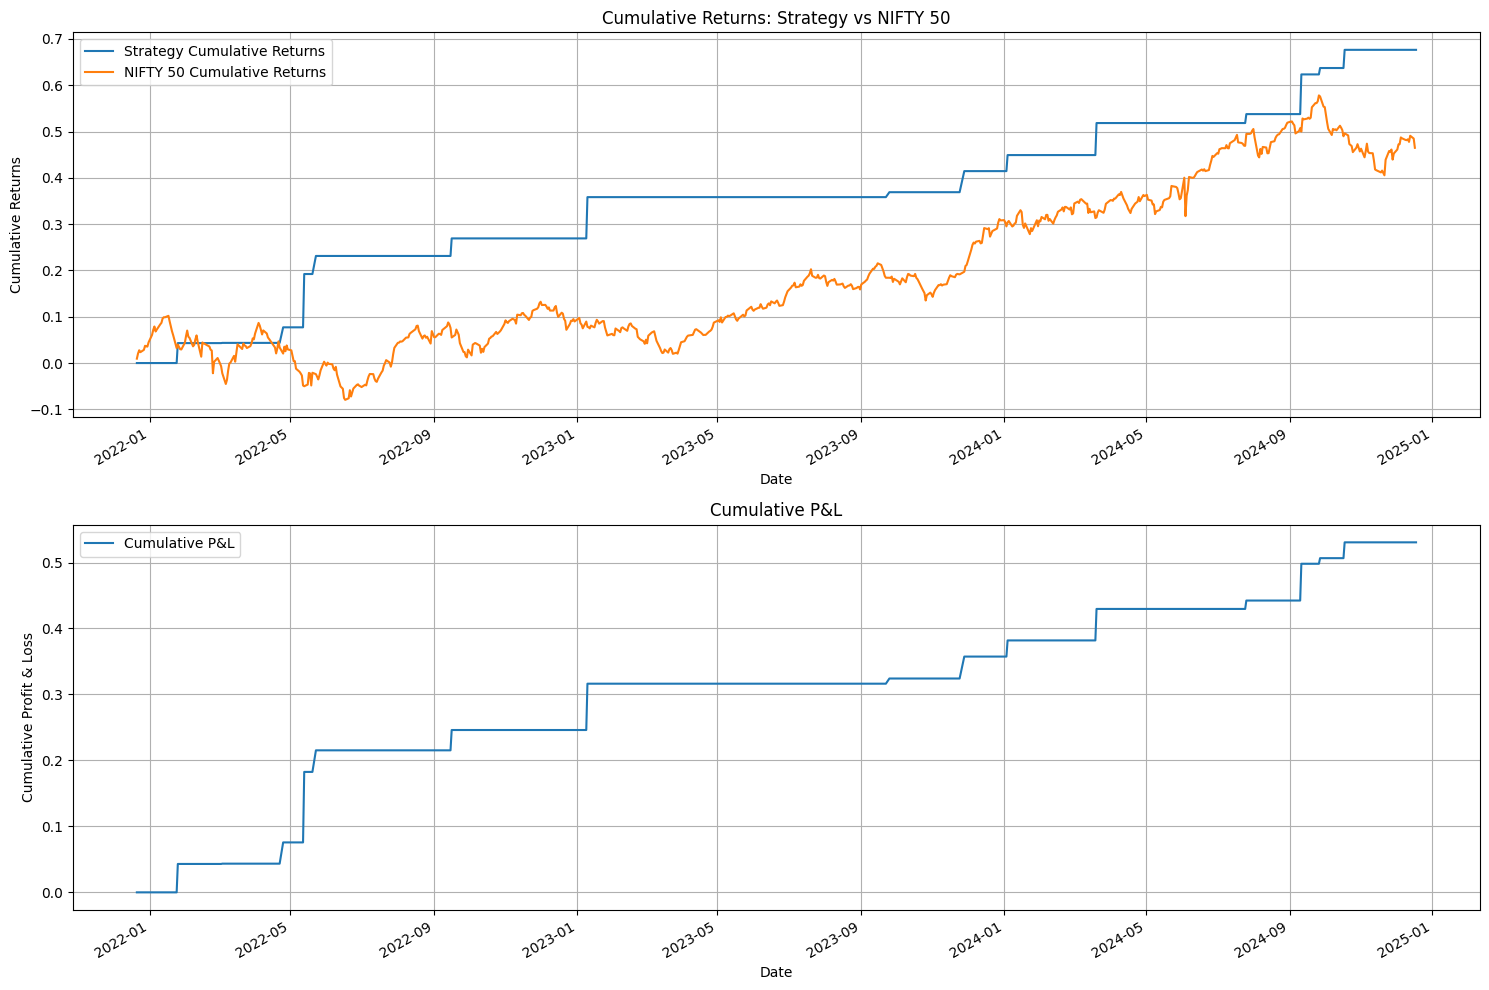

{'Total Return': 0.6763664836641246, 'Benchmark Return': 0.46477116829895415, 'Sharpe Ratio': 1.8218807033027895, 'Maximum Drawdown': 0.0, 'Annual Volatility': 0.0991751720260905}


In [11]:
#backtesting my strategy
def backtest_statistical_arbitrage(closing_prices, signals, initial_capital=100000):
    """
    Perform backtesting for a statistical arbitrage strategy.

    Parameters:
    -----------
    closing_prices : pandas.DataFrame
        DataFrame with closing prices for both stocks
    signals : pandas.DataFrame
        DataFrame with trading signals for both stocks
    initial_capital : float, optional
        Initial capital for the strategy (default: $100,000)

    Returns:
    --------
    backtest_results : dict
        Dictionary containing various performance metrics and DataFrames
    """
    # Identify stock columns
    stock1 = closing_prices.columns[0]
    stock2 = closing_prices.columns[1]
    signal_col1 = f'{stock1}_signal'
    signal_col2 = f'{stock2}_signal'

    # Create a copy of closing prices and signals
    prices = closing_prices.copy()
    strategy_signals = signals.copy()

    # Calculate daily returns for both stocks
    prices['returns_1'] = prices[stock1].pct_change()
    prices['returns_2'] = prices[stock2].pct_change()

    # Initialize portfolio tracking variables
    portfolio = pd.DataFrame(index=prices.index)
    portfolio['signal_1'] = strategy_signals[signal_col1]
    portfolio['signal_2'] = strategy_signals[signal_col2]

    # Calculate position-weighted returns
    portfolio['stock1_strategy_return'] = portfolio['signal_1'] * prices['returns_1']
    portfolio['stock2_strategy_return'] = portfolio['signal_2'] * prices['returns_2']
    portfolio['strategy_return'] = portfolio['stock1_strategy_return'] + portfolio['stock2_strategy_return']

    # Calculate cumulative strategy returns
    portfolio['cumulative_strategy_return'] = (1 + portfolio['strategy_return']).cumprod() - 1

    # Calculate benchmark returns (using NIFTY 50)
    nifty = yf.download('^NSEI', start=prices.index[0], end=prices.index[-1])['Close']
    nifty_returns = nifty.pct_change()

    portfolio['benchmark_return'] = nifty_returns
    portfolio['cumulative_benchmark_return'] = (1 + nifty_returns).cumprod() - 1

    # Performance Calculations
    sharpe_ratio = portfolio['strategy_return'].mean() / portfolio['strategy_return'].std() * np.sqrt(252)
    max_drawdown = (portfolio['cumulative_strategy_return'] - portfolio['cumulative_strategy_return'].cummax()).min()

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    portfolio['cumulative_strategy_return'].plot(label='Strategy Cumulative Returns')
    portfolio['cumulative_benchmark_return'].plot(label='NIFTY 50 Cumulative Returns')
    plt.title('Cumulative Returns: Strategy vs NIFTY 50')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    portfolio['strategy_return'].cumsum().plot(label='Cumulative P&L')
    plt.title('Cumulative P&L')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Profit & Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Performance Summary
    performance_summary = {
        'Total Return': portfolio['cumulative_strategy_return'].iloc[-1],
        'Benchmark Return': portfolio['cumulative_benchmark_return'].iloc[-2],
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Annual Volatility': portfolio['strategy_return'].std() * np.sqrt(252)
    }

    return {
        'portfolio': portfolio,
        'performance': performance_summary,
        'signals': strategy_signals
    }

results = backtest_statistical_arbitrage(closing_prices, signals)
print(results['performance'])

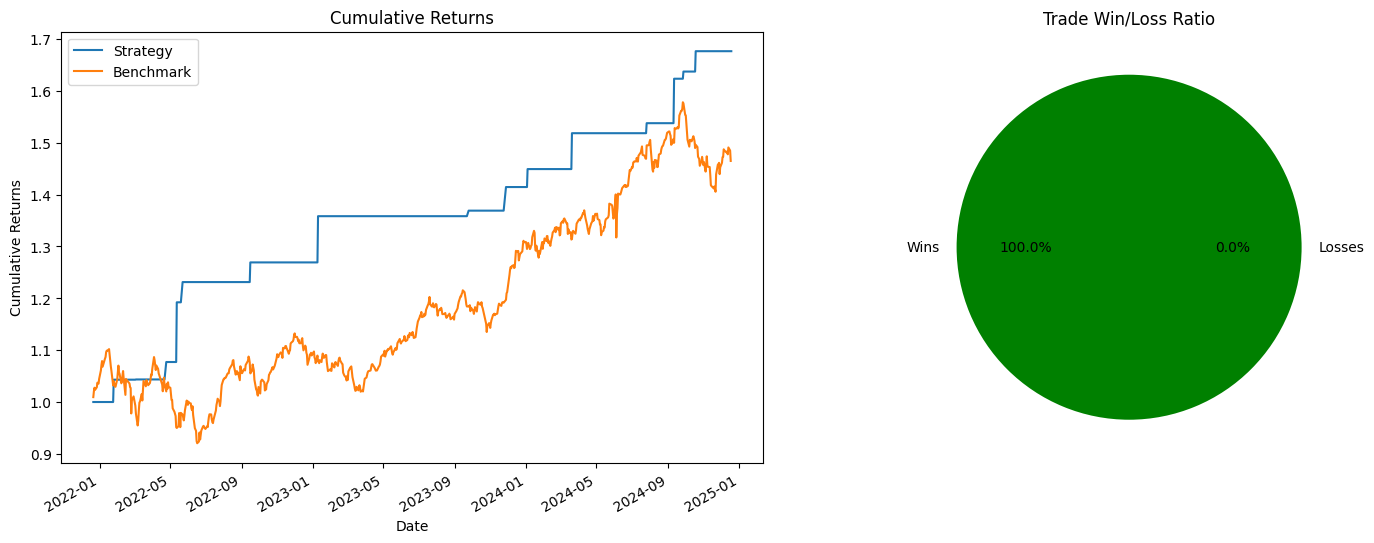


--- Strategy Performance Summary ---

Sharpe Ratio:
  1.8218807033027895

Maximum Drawdown:
  Value: 0.0
  Percentage: 0.0

Win Rate:
  Value: 100.0
  Wins: 15
  Total Trades: 15

Returns:
  Strategy Total Return: 67.63664836641246
  Benchmark Total Return: 46.477116829895415
  Relative Performance: 21.15953153651704

Detailed Metrics:
  Average Daily Return: 0.0007170052863534478
  Daily Volatility: 0.0062474486050734575
  Annualized Return: 19.20751013896198
  Annualized Volatility: 9.91751720260905


In [12]:
def evaluate_strategy_performance(backtest_results):
    """
    Comprehensive performance evaluation of the trading strategy.

    Parameters:
    -----------
    backtest_results : dict
        Results from the backtesting function

    Returns:
    --------
    performance_metrics : dict
        Detailed performance metrics of the strategy
    """
    # Extract portfolio data from backtest results
    portfolio = backtest_results['portfolio']

    # 1. Sharpe Ratio Calculation
    # Assuming risk-free rate is 0 (can be modified)
    risk_free_rate = 0
    sharpe_ratio = (portfolio['strategy_return'].mean() - risk_free_rate) / portfolio['strategy_return'].std() * np.sqrt(252)

    # 2. Maximum Drawdown Calculation
    cumulative_returns = (1 + portfolio['strategy_return']).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # 3. Win Rate Calculation
    # A trade is considered a win if it generates a positive return
    strategy_returns = portfolio['strategy_return']
    wins = strategy_returns[strategy_returns > 0]
    losses = strategy_returns[strategy_returns < 0]

    win_rate = len(wins) / (len(wins) + len(losses)) * 100

    # 4. Total Return Comparison
    strategy_total_return = (1 + portfolio['strategy_return']).prod() - 1
    benchmark_total_return = (1 + portfolio['benchmark_return']).prod() - 1

    # Additional Performance Metrics
    total_trading_days = len(portfolio)
    average_daily_return = portfolio['strategy_return'].mean()
    daily_volatility = portfolio['strategy_return'].std()

    # Annualized Metrics (assuming 252 trading days)
    annualized_return = ((1 + strategy_total_return) ** (252 / total_trading_days)) - 1
    annualized_volatility = daily_volatility * np.sqrt(252)

    # Performance Summary
    performance_metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': {
            'Value': max_drawdown,
            'Percentage': max_drawdown * 100
        },
        'Win Rate': {
            'Value': win_rate,
            'Wins': len(wins),
            'Total Trades': len(wins) + len(losses)
        },
        'Returns': {
            'Strategy Total Return': strategy_total_return * 100,
            'Benchmark Total Return': benchmark_total_return * 100,
            'Relative Performance': (strategy_total_return - benchmark_total_return) * 100
        },
        'Detailed Metrics': {
            'Average Daily Return': average_daily_return,
            'Daily Volatility': daily_volatility,
            'Annualized Return': annualized_return * 100,
            'Annualized Volatility': annualized_volatility * 100
        }
    }

    # Visualization of Performance Metrics
    plt.figure(figsize=(15, 10))

    # Cumulative Returns Comparison
    plt.subplot(2, 2, 1)
    (1 + portfolio['strategy_return']).cumprod().plot(label='Strategy')
    (1 + portfolio['benchmark_return']).cumprod().plot(label='Benchmark')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()

    # Win/Loss Ratio
    plt.subplot(2, 2, 2)
    plt.pie([len(wins), len(losses)],
            labels=['Wins', 'Losses'],
            autopct='%1.1f%%',
            colors=['green', 'red'])
    plt.title('Trade Win/Loss Ratio')

    plt.tight_layout()
    plt.show()

    # Print Performance Summary
    print("\n--- Strategy Performance Summary ---")
    for key, value in performance_metrics.items():
        print(f"\n{key}:")
        if isinstance(value, dict):
            for subkey, subvalue in value.items():
                print(f"  {subkey}: {subvalue}")
        else:
            print(f"  {value}")

    return performance_metrics

performance = evaluate_strategy_performance(results)